<a href="https://colab.research.google.com/github/gustavomfb231/ProjetoCIS/blob/main/ProjetoCIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importando os módulos utilizados

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ShuffleSplit,cross_val_score,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
!pip install catboost
!pip install scikit-optimize
!pip install xgboost
!pip install lightgbm
from lightgbm import LGBMClassifier
import catboost as ctb
from skopt import BayesSearchCV
from scipy.stats import loguniform
from xgboost import XGBClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.6 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

Definindo a SEED para obter resultados replicáveis

In [ ]:
SEED = 0
np.random.seed(SEED)

Baixando e descomprimindo o Dataset do Kaggle

In [ ]:
!chmod 600 /root/.kaggle

In [ ]:
!kaggle competitions download -c spaceship-titanic

100% 299k/299k [00:00<00:00, 646kB/s]
100% 299k/299k [00:00<00:00, 646kB/s]


In [ ]:
!unzip spaceship-titanic.zip

Archive:  spaceship-titanic.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


Extraindo os dados de treino

In [ ]:
data_train = pd.read_csv("/content/train.csv")
x_train = data_train.drop(columns=["Transported","Name"],axis=1)
y_train= data_train[["Transported"]]

Extraindo os dados de teste

In [ ]:
x_test = pd.read_csv("/content/test.csv")

Transformando as variáveis do tipo bool para tipo int

In [ ]:
binarizando = {False:int(0), True:int(1)}
x_train["VIP"] = x_train["VIP"].map(binarizando)
x_train["CryoSleep"] = x_train["CryoSleep"].map(binarizando)

In [ ]:
x_train.head(15)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0001_01,Europa,0.0,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0002_01,Earth,0.0,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0
2,0003_01,Europa,0.0,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0
3,0003_02,Europa,0.0,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0
4,0004_01,Earth,0.0,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0
5,0005_01,Earth,0.0,F/0/P,PSO J318.5-22,44.0,0.0,0.0,483.0,0.0,291.0,0.0
6,0006_01,Earth,0.0,F/2/S,TRAPPIST-1e,26.0,0.0,42.0,1539.0,3.0,0.0,0.0
7,0006_02,Earth,1.0,G/0/S,TRAPPIST-1e,28.0,0.0,0.0,0.0,0.0,0.0,NaN
8,0007_01,Earth,0.0,F/3/S,TRAPPIST-1e,35.0,0.0,0.0,785.0,17.0,216.0,0.0
9,0008_01,Europa,1.0,B/1/P,55 Cancri e,14.0,0.0,0.0,0.0,0.0,0.0,0.0


Transformando as features categoricas em números

In [ ]:
x_categorical = x_train[["HomePlanet","Destination"]]
ohe = OneHotEncoder()
x_categorical_v2 = ohe.fit_transform(x_categorical)
dense_matrix = x_categorical_v2.toarray()
ohe_columns = ohe.get_feature_names_out(["HomePlanet","Destination"])
x_categorical_df = pd.DataFrame(dense_matrix,columns=ohe_columns)
x_categorical_result = x_categorical_df


Preenchendo os valores nulos das features numéricas

In [ ]:
x_numerico = x_train.drop(["HomePlanet","Cabin","Destination","PassengerId"],axis=1)
x_numerico["Age"].fillna(x_numerico["Age"].mean(),inplace=True)
x_numerico["VIP"].fillna(0,inplace=True)
x_numerico["CryoSleep"].fillna(0,inplace=True)
x_numerico["RoomService"].fillna(x_numerico["RoomService"].mean(),inplace=True)
x_numerico["FoodCourt"].fillna(x_numerico["FoodCourt"].mean(),inplace=True)
x_numerico["ShoppingMall"].fillna(x_numerico["ShoppingMall"].mean(),inplace=True)
x_numerico["Spa"].fillna(x_numerico["Spa"].mean(),inplace=True)
x_numerico["VRDeck"].fillna(x_numerico["VRDeck"].mean(),inplace=True)
x_numerico_df = x_numerico
x_numerico.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0
2,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0
3,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0
4,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0


Visualizando o x_numerico e padronizando ele

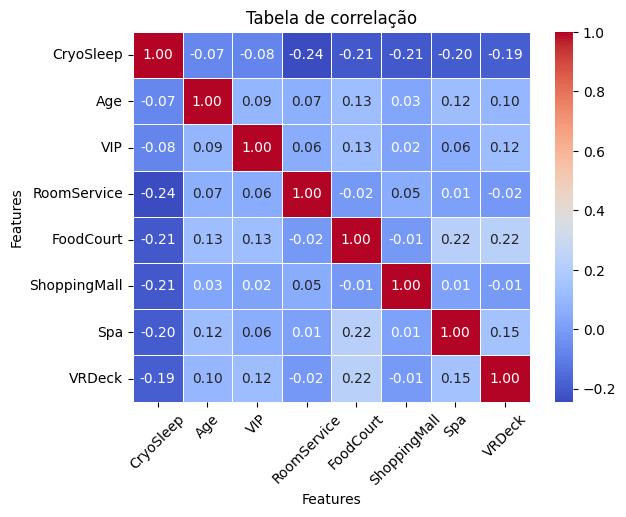

In [ ]:
scaler = StandardScaler()
x_visual = scaler.fit_transform(x_numerico_df)
x_visual = pd.DataFrame(x_visual,columns=x_numerico.columns)
correlation_matrix = x_visual.corr()
sns.heatmap(correlation_matrix, cmap="coolwarm",annot=True,linewidths=0.4,fmt=".2f")
plt.xlabel("Features")
plt.ylabel("Features")
plt.title("Tabela de correlação")
plt.xticks(rotation=45)
plt.show()

Concatenando os dois tipos de features e padronizando elas

In [ ]:
scaler = StandardScaler()
pd.set_option("display.max_columns",200)
x_train_v2 = pd.concat([x_categorical_result,x_numerico_df],axis=1)
x_scaler = scaler.fit_transform(x_train_v2)
x_train_v3 = pd.DataFrame(x_scaler,columns=x_train_v2.columns)

In [ ]:
def testando_modelo(n):
  cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
  intervalo = cross_val_score(n,x_train_v3,y_train_v2,cv=cv)
  print(f"O intervalo de precisão de {n} é entre {(intervalo.mean() - 2*intervalo.std()):.3f} e {(intervalo.mean() + 2*intervalo.std()):.3f}")


- Testando modelo de árvore de decisão

In [ ]:
model = DecisionTreeClassifier(random_state=0)
y_train_v2 = y_train["Transported"].map(binarizando)
model.fit(x_train_v3,y_train_v2)
testando_modelo(model)

O intervalo de precisão é entre 0.723 e 0.754


- Testando outro modelo de árvore de decisão
  - Tempo de processamento relativamente maior que o ForestTreeClassifier

In [ ]:
model_v2 = RandomForestClassifier(random_state=0)
model_v2.fit(x_train_v3,y_train_v2)
testando_modelo(model_v2)

O intervalo de precisão é entre 0.771 e 0.795


- Testando um modelo probabilístico

In [ ]:
model_v3 = BernoulliNB(random_state=0)
model_v3.fit(x_train_v3,y_train_v2)
testando_modelo(model_v3)

O intervalo de precisão é entre 0.733 e 0.771


- Testando modelo Ensemble de gradiente
  - Melhor resultado obtido

In [ ]:
model_v4 = GradientBoostingClassifier()
model_v4.fit(x_train_v3,y_train_v2)
testando_modelo(model_v4)

O intervalo de precisão é entre 0.772 e 0.811


Tratando os dados de teste e salvando para submissão deles

In [ ]:
x_test_v1 = x_test.drop(["Name","PassengerId"],axis=1)

In [ ]:
x_test_v1["CryoSleep"]= x_test_v1["CryoSleep"].map(binarizando)
x_test_v1["VIP"]= x_test_v1["VIP"].map(binarizando)

In [ ]:
x_categorical_test = x_test_v1[["HomePlanet","Destination"]]
x_numerical_test = x_test_v1.drop(["HomePlanet","Destination","Cabin"],axis=1)
x_numerical_test["Age"].fillna(x_numerical_test["Age"].mean(),inplace=True)
x_numerical_test["VIP"].fillna(0,inplace=True)
x_numerical_test["CryoSleep"].fillna(0,inplace=True)
x_numerical_test["RoomService"].fillna(x_numerical_test["RoomService"].mean(),inplace=True)
x_numerical_test["FoodCourt"].fillna(x_numerical_test["FoodCourt"].mean(),inplace=True)
x_numerical_test["ShoppingMall"].fillna(x_numerical_test["ShoppingMall"].mean(),inplace=True)
x_numerical_test["Spa"].fillna(x_numerical_test["Spa"].mean(),inplace=True)
x_numerical_test["VRDeck"].fillna(x_numerical_test["VRDeck"].mean(),inplace=True)
impute = SimpleImputer(strategy="most_frequent")
ohe = OneHotEncoder()
x_numerical_df = x_numerical_test
x_categorical_ohe = ohe.fit_transform(x_categorical_test)
x_categorical_array = x_categorical_ohe.toarray()
ohe_columns = ohe.get_feature_names_out(["HomePlanet","Destination"])
x_categorical_teste_df = pd.DataFrame(x_categorical_array,columns=ohe_columns)


In [ ]:
x_test_final = pd.concat([x_categorical_teste_df,x_numerical_df],axis=1)

In [ ]:
y_predict = model_v4.predict(x_test_final)
y_predict_df = pd.DataFrame(y_predict,columns=y_train.columns)
submission_df = pd.concat([x_test["PassengerId"],y_predict_df],axis=1)
submission_df["Transported"] = submission_df["Transported"].map({0:False,1:True})
submission_df.to_csv("/content/submission_3.csv",index=False)

Clusterizando os grupos de passsageiro e visualizando para analisar padrões para tentar encontrar diferenças entre os transportados e não-transportados



<ipython-input-24-2364df440a28>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_transportados.drop(["Transported"],axis=1,inplace=True)
<ipython-input-24-2364df440a28>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_nao_transportados.drop(["Transported"],axis=1,inplace=True)


<Axes: xlabel='PCA1', ylabel='PCA2'>

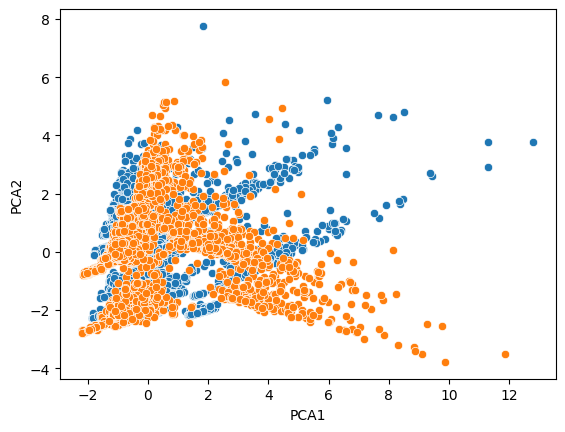

In [ ]:
tabela_final = pd.concat([x_train_v3,y_train_v2],axis=1)
x_transportados = tabela_final[tabela_final["Transported"] == 1]
x_transportados.drop(["Transported"],axis=1,inplace=True)
x_nao_transportados = tabela_final[tabela_final["Transported"] == 0]
x_nao_transportados.drop(["Transported"],axis=1,inplace=True)
pipeline = Pipeline([("scaler",StandardScaler()),("pca",PCA(n_components=2))])
data_pipeline = pipeline.fit_transform(x_transportados)
pipeline_df = pd.DataFrame(data_pipeline,columns=["PCA1","PCA2"])
data_pipeline_1 = pipeline.fit_transform(x_nao_transportados)
pipeline_df_1 = pd.DataFrame(data_pipeline_1,columns=["PCA1","PCA2"])
sns.scatterplot(x="PCA1",y="PCA2",data=pipeline_df)
sns.scatterplot(x="PCA1",y="PCA2",data=pipeline_df_1)
plt.show()

Tratando os dados para tentar obter melhor desempenho na classificação

In [ ]:
ohe_v1 = OneHotEncoder()
x_categorical[["deck","num","side"]] = x_train.Cabin.str.split("/",expand=True)
x_categorical_num = x_categorical["num"]
x_categorical_num.fillna(0,inplace=True)
x_categorical.drop(["num"],axis=1,inplace=True)
ohe_categorical_train = ohe_v1.fit_transform(x_categorical)
dense_matrix_v2 = ohe_categorical_train.toarray()
ohe_columns = ohe_v1.get_feature_names_out(["HomePlanet","Destination","deck","side"])
x_categorical_df_v2 = pd.DataFrame(dense_matrix_v2,columns=ohe_columns)
x_train_v4 = pd.concat([x_categorical_df_v2,x_categorical_num,x_numerico_df],axis=1)

<ipython-input-25-dcf59b688789>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_categorical[["deck","num","side"]] = x_train.Cabin.str.split("/",expand=True)
<ipython-input-25-dcf59b688789>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_categorical[["deck","num","side"]] = x_train.Cabin.str.split("/",expand=True)
<ipython-input-25-dcf59b688789>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

- Testando novos modelos com os dados tratados junto com as informações da Cabine

In [ ]:
def testando_modelo_v2(n):
  cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
  intervalo_2 = cross_val_score(n,x_train_v4,y_train_v2,cv=cv)
  print(f"O intervalo de precisão de {n} é entre {(intervalo_2.mean() - 2*intervalo_2.std()):.3f} e {(intervalo_2.mean() + 2*intervalo_2.std()):.3f}")

In [ ]:
model_v2 = RandomForestClassifier(random_state=0)
model_v2.fit(x_train_v4,y_train_v2)
testando_modelo_v2(model_v2)

O intervalo de precisão de RandomForestClassifier() é entre 0.771 e 0.832


In [ ]:
ctb_model = ctb.CatBoostClassifier(verbose=0,random_state=0)
ctb_model.fit(x_train_v4,y_train_v2)
testando_modelo_v2(ctb_model)

O intervalo de precisão de <catboost.core.CatBoostClassifier object at 0x79f97a12de40> é entre 0.798 e 0.831


In [ ]:
xgbc_model = XGBClassifier(random_state=0)
x_train_v4["num"] = x_train_v4["num"].apply(int)
xgbc_model.fit(x_train_v4,y_train_v2)
testando_modelo_v2(xgbc_model)

O intervalo de precisão de XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) é entre 0.779 e 0.836


Tratando o teste desse novo modo e salvando as previsões para enviar no Kaggle

In [ ]:
ohe_v2= OneHotEncoder()
x_categorical_test[["deck","num","side"]] = x_test_v1.Cabin.str.split("/",expand=True)
x_categorical_num_test = x_categorical_test["num"]
x_categorical_num_test.fillna(0,inplace=True)
x_categorical_test.drop(["num"],axis=1,inplace=True)
ohe_test = ohe_v2.fit_transform(x_categorical_test)
ohe_array = ohe_test.toarray()
ohe_columns = ohe_v2.get_feature_names_out(["HomePlanet","Destination","deck","side"])
x_categorical_test_v3 = pd.DataFrame(ohe_array,columns=ohe_columns)
x_test_final = pd.concat([x_categorical_test_v3,x_categorical_num_test,x_numerical_df],axis=1)

<ipython-input-30-08c22fbb9ba1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_categorical_test[["deck","num","side"]] = x_test_v1.Cabin.str.split("/",expand=True)
<ipython-input-30-08c22fbb9ba1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_categorical_test[["deck","num","side"]] = x_test_v1.Cabin.str.split("/",expand=True)
<ipython-input-30-08c22fbb9ba1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [ ]:
x_test_final.num = x_test_final.num.apply(int)
y_predict = xgbc_model.predict(x_test_final)
y_predict_df = pd.DataFrame(y_predict,columns=y_train.columns)
submission_df = pd.concat([x_test["PassengerId"],y_predict_df],axis=1)
submission_df["Transported"] = submission_df["Transported"].map({0:False,1:True})
submission_df.to_csv("/content/submission_11.csv",index=False)

Novo tratamento dos dados de treino - Incluido o grupo da pessoa

In [ ]:
id_treino = pd.DataFrame(data_train["PassengerId"])
id_treino[["Grupo","Id"]] = data_train.PassengerId.str.split("_",expand=True)
id_treino.drop(["Id","PassengerId"],inplace=True,axis=1)
x_train_v5 = pd.concat([x_train_v4,id_treino],axis=1)

In [ ]:
def testando_modelo_v3(n):
  cv = StratifiedKFold(shuffle=True,n_splits=5,random_state=0)
  intervalo = cross_val_score(n,x_train_v5,y_train_v2,cv=cv)
  print(f"O intervalo de precisão de {n} é entre {(intervalo.mean() - 2*intervalo.std()):.3f} e {(intervalo.mean() + 2*intervalo.std()):.3f}")


Testando modelo LightGBM

In [ ]:
x_train_v5["Grupo"],x_train_v5["num"] = x_train_v5["Grupo"].apply(int),x_train_v5["num"].apply(int)
lgbm_model = LGBMClassifier(random_state=0)
lgbm_model.fit(x_train_v5,y_train_v2)
testando_modelo_v3(lgbm_model)

O intervalo de precisão de LGBMClassifier() é entre 0.797 e 0.817


Testando os modelos passados com os dados pós novo tratamento

In [ ]:
modelos_teste = [GradientBoostingClassifier(random_state=0),XGBClassifier(random_state=0),RandomForestClassifier(random_state=0),ctb.CatBoostClassifier(verbose=0,random_state=0)]
x_train_v5["Grupo"] = x_train_v5["Grupo"].apply(int)
for i in modelos_teste:
  model = i
  model.fit(x_train_v5,y_train_v2)
  testando_modelo_v3(model)

O intervalo de precisão de GradientBoostingClassifier() é entre 0.789 e 0.824
O intervalo de precisão de XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) é entre 0.777 e 0.832
O intervalo de precisão de RandomForestClassifier() é entre 0.787 e 0.805
O intervalo de precisão de <catboost.core.CatBo

Tratando os dados de teste incluindo o grupo da pessoa e salvando as previsões para submissão

In [ ]:
id_teste = pd.DataFrame(x_test["PassengerId"])
id_teste[["Grupo","Id"]] = id_teste["PassengerId"].str.split("_",expand=True)
id_teste.drop(["Id","PassengerId"],axis=1,inplace=True)
x_test_final_v2 = pd.concat([x_test_final,id_teste],axis=1)

In [ ]:
x_test_final_v2["Grupo"] = x_test_final_v2["Grupo"].apply(int)
x_test_final_v2["num"] = x_test_final_v2["num"].apply(int)
y_predict = lgbm_model.predict(x_test_final_v2)
y_predict_df = pd.DataFrame(y_predict,columns=y_train.columns)
submission_df = pd.concat([x_test["PassengerId"],y_predict_df],axis=1)
submission_df["Transported"] = submission_df["Transported"].map({0:False,1:True})
submission_df.to_csv("/content/lgbm_model.csv",index=False)

Análise exploratória dos dados em busca de melhorar o modelo

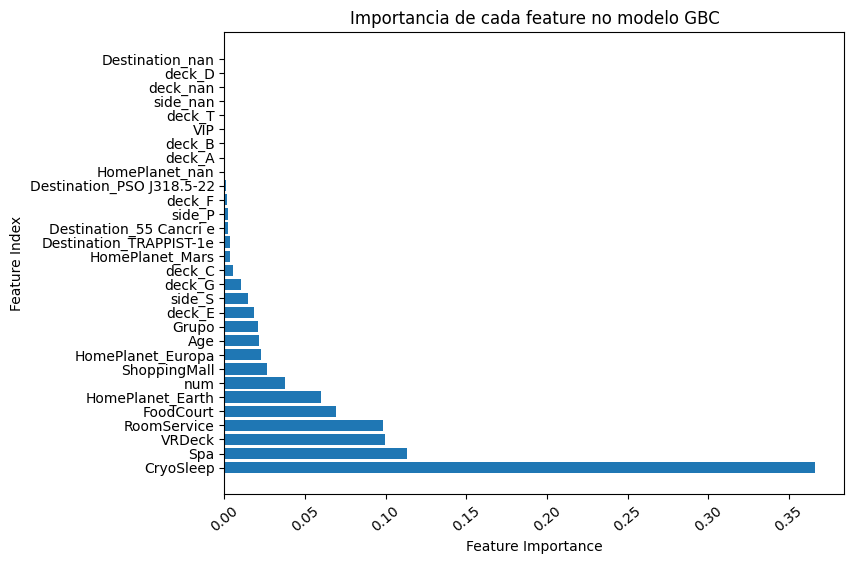

In [ ]:
model_v4.fit(x_train_v5,y_train_v2)
col_importances = model_v4.feature_importances_
sorted_index = col_importances.argsort()[::-1]
sorted_col_importances = col_importances[sorted_index]
plt.figure(figsize=(8,6))
plt.barh(range(x_train_v5.shape[1]),sorted_col_importances,tick_label = x_train_v5.columns[sorted_index])
plt.xticks(rotation=40)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Index")
plt.title("Importancia de cada feature no modelo GBC")
plt.show()

Heatmap da correlação entre as variáveis e o transported


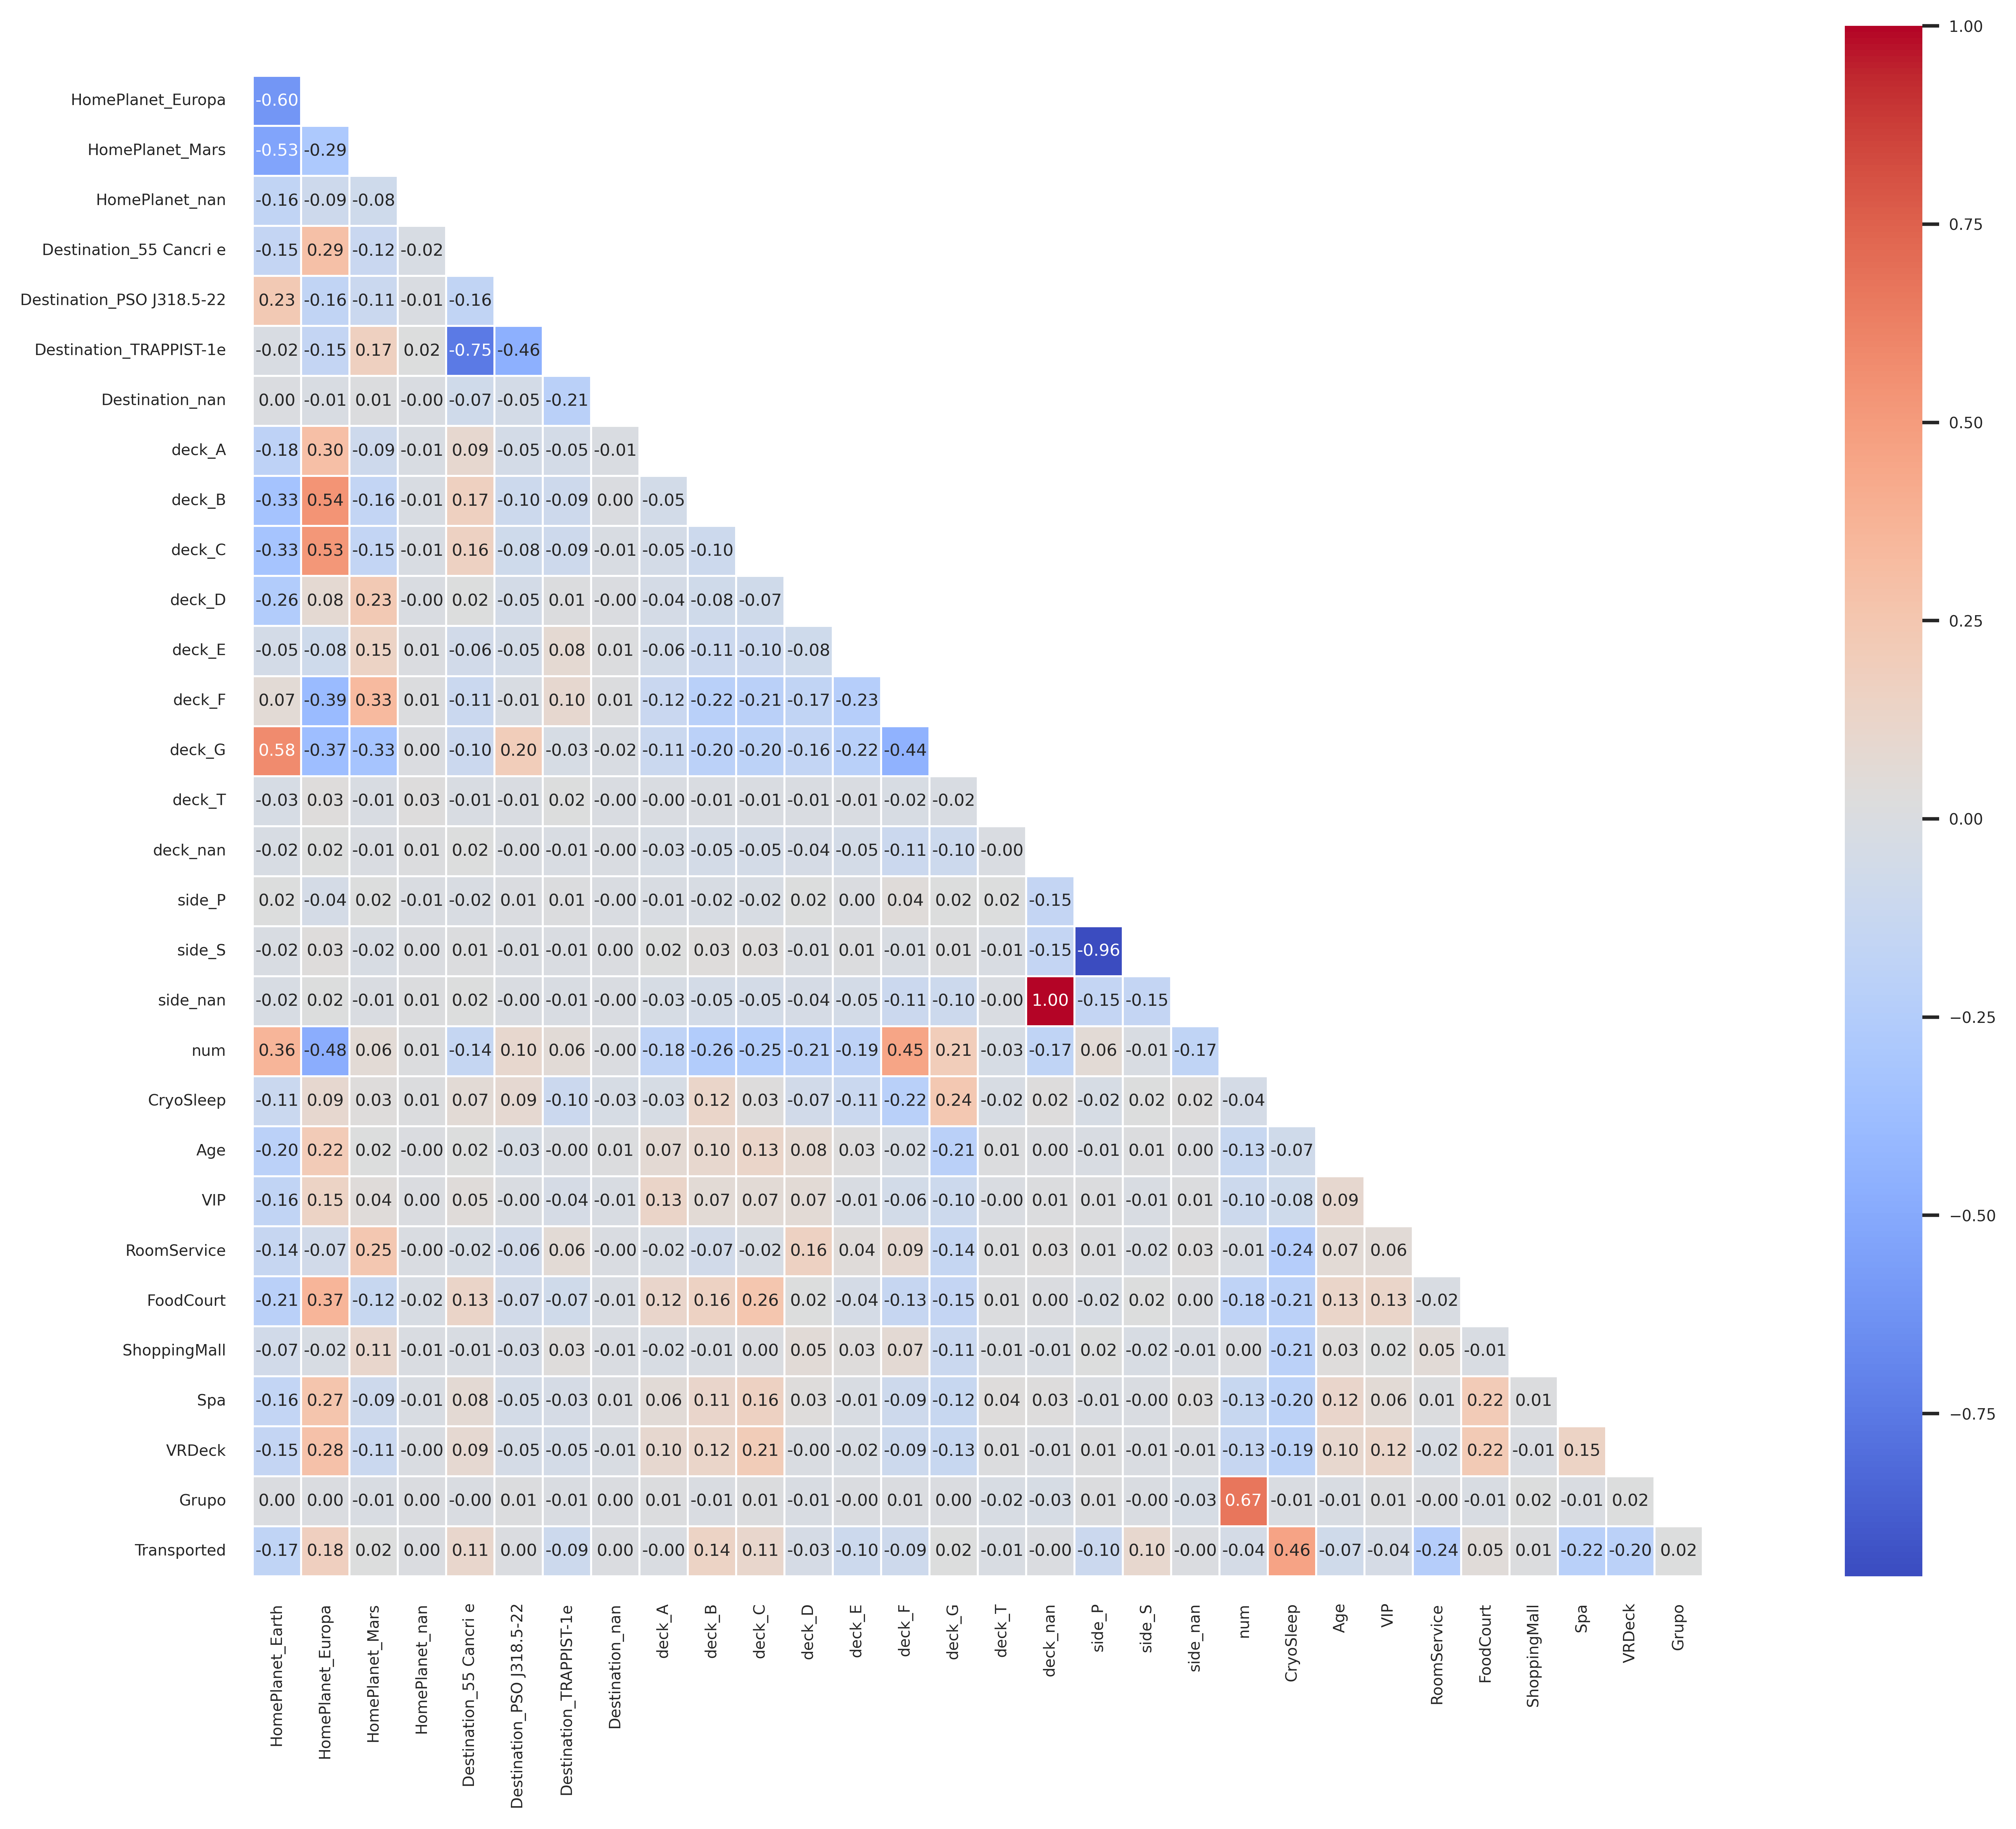

In [ ]:
correlation_matrix = pd.concat([x_train_v5,y_train_v2],axis=1).corr()
mask = np.triu(np.ones_like(correlation_matrix,dtype=bool))
sns.set(font_scale=0.5)
fig,ax =plt.subplots(figsize=(12,10),dpi=600)
plt.gca().set_facecolor("white")
sns.heatmap(correlation_matrix,annot=True,fmt=".2f",cmap="coolwarm",linewidths=0.5,mask=mask,ax=ax)
labels_y = ax.get_yticklabels()[1::]
labels_x = ax.get_xticklabels()[0:-1]
positions_x = []
for i in range(len(labels_x)):
  i += 0.5
  positions_x.append(i)
positions_y = []
for j in positions_x:
  j+= 1
  positions_y.append(j)
ax.set_xticks(positions_x)
ax.set_xticklabels(labels_x)
ax.set_yticks(positions_y)
ax.set_yticklabels(labels_y)
plt.xticks(rotation=90)
plt.show()

Removendo features com base na matriz de correlação e na importancia de cada feature no modelo GBC

In [ ]:
x_train_v6 = x_train_v5.drop(["deck_nan","Destination_nan","HomePlanet_nan","side_P","deck_T","side_nan","VIP"],axis=1)


Testando a performance do modelo GBC com esses dados pós tratamento

In [ ]:
def testando_modelo_v4(n):
  cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
  intervalo = cross_val_score(n,x_train_v6,y_train_v2,cv=cv)
  print(f"O intervalo de precisão de {n} é entre {(intervalo.mean() - 2*intervalo.std()):.3f} e {(intervalo.mean() + 2*intervalo.std()):.3f}")

In [ ]:
model_test = GradientBoostingClassifier(random_state=0)
model_test.fit(x_train_v6,y_train_v2)
testando_modelo_v4(model_test)

O intervalo de precisão de GradientBoostingClassifier() é entre 0.796 e 0.816


Testando todos os modelos com os dados pós tratamento

In [ ]:
modelos_teste = [LGBMClassifier(random_state=0),GradientBoostingClassifier(random_state=0),XGBClassifier(random_state=0),RandomForestClassifier(random_state=0),ctb.CatBoostClassifier(verbose=0,random_state=0)]
for i in modelos_teste:
  model = i
  model.fit(x_train_v6,y_train_v2)
  testando_modelo_v4(model)

O intervalo de precisão de LGBMClassifier() é entre 0.782 e 0.832
O intervalo de precisão de GradientBoostingClassifier() é entre 0.792 e 0.819
O intervalo de precisão de XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) é entre 0.770 e 0.836
O intervalo de precisão de RandomForestClassifier() é e

Plotando gráfico dos resultados do cross validation score do modelo GBC

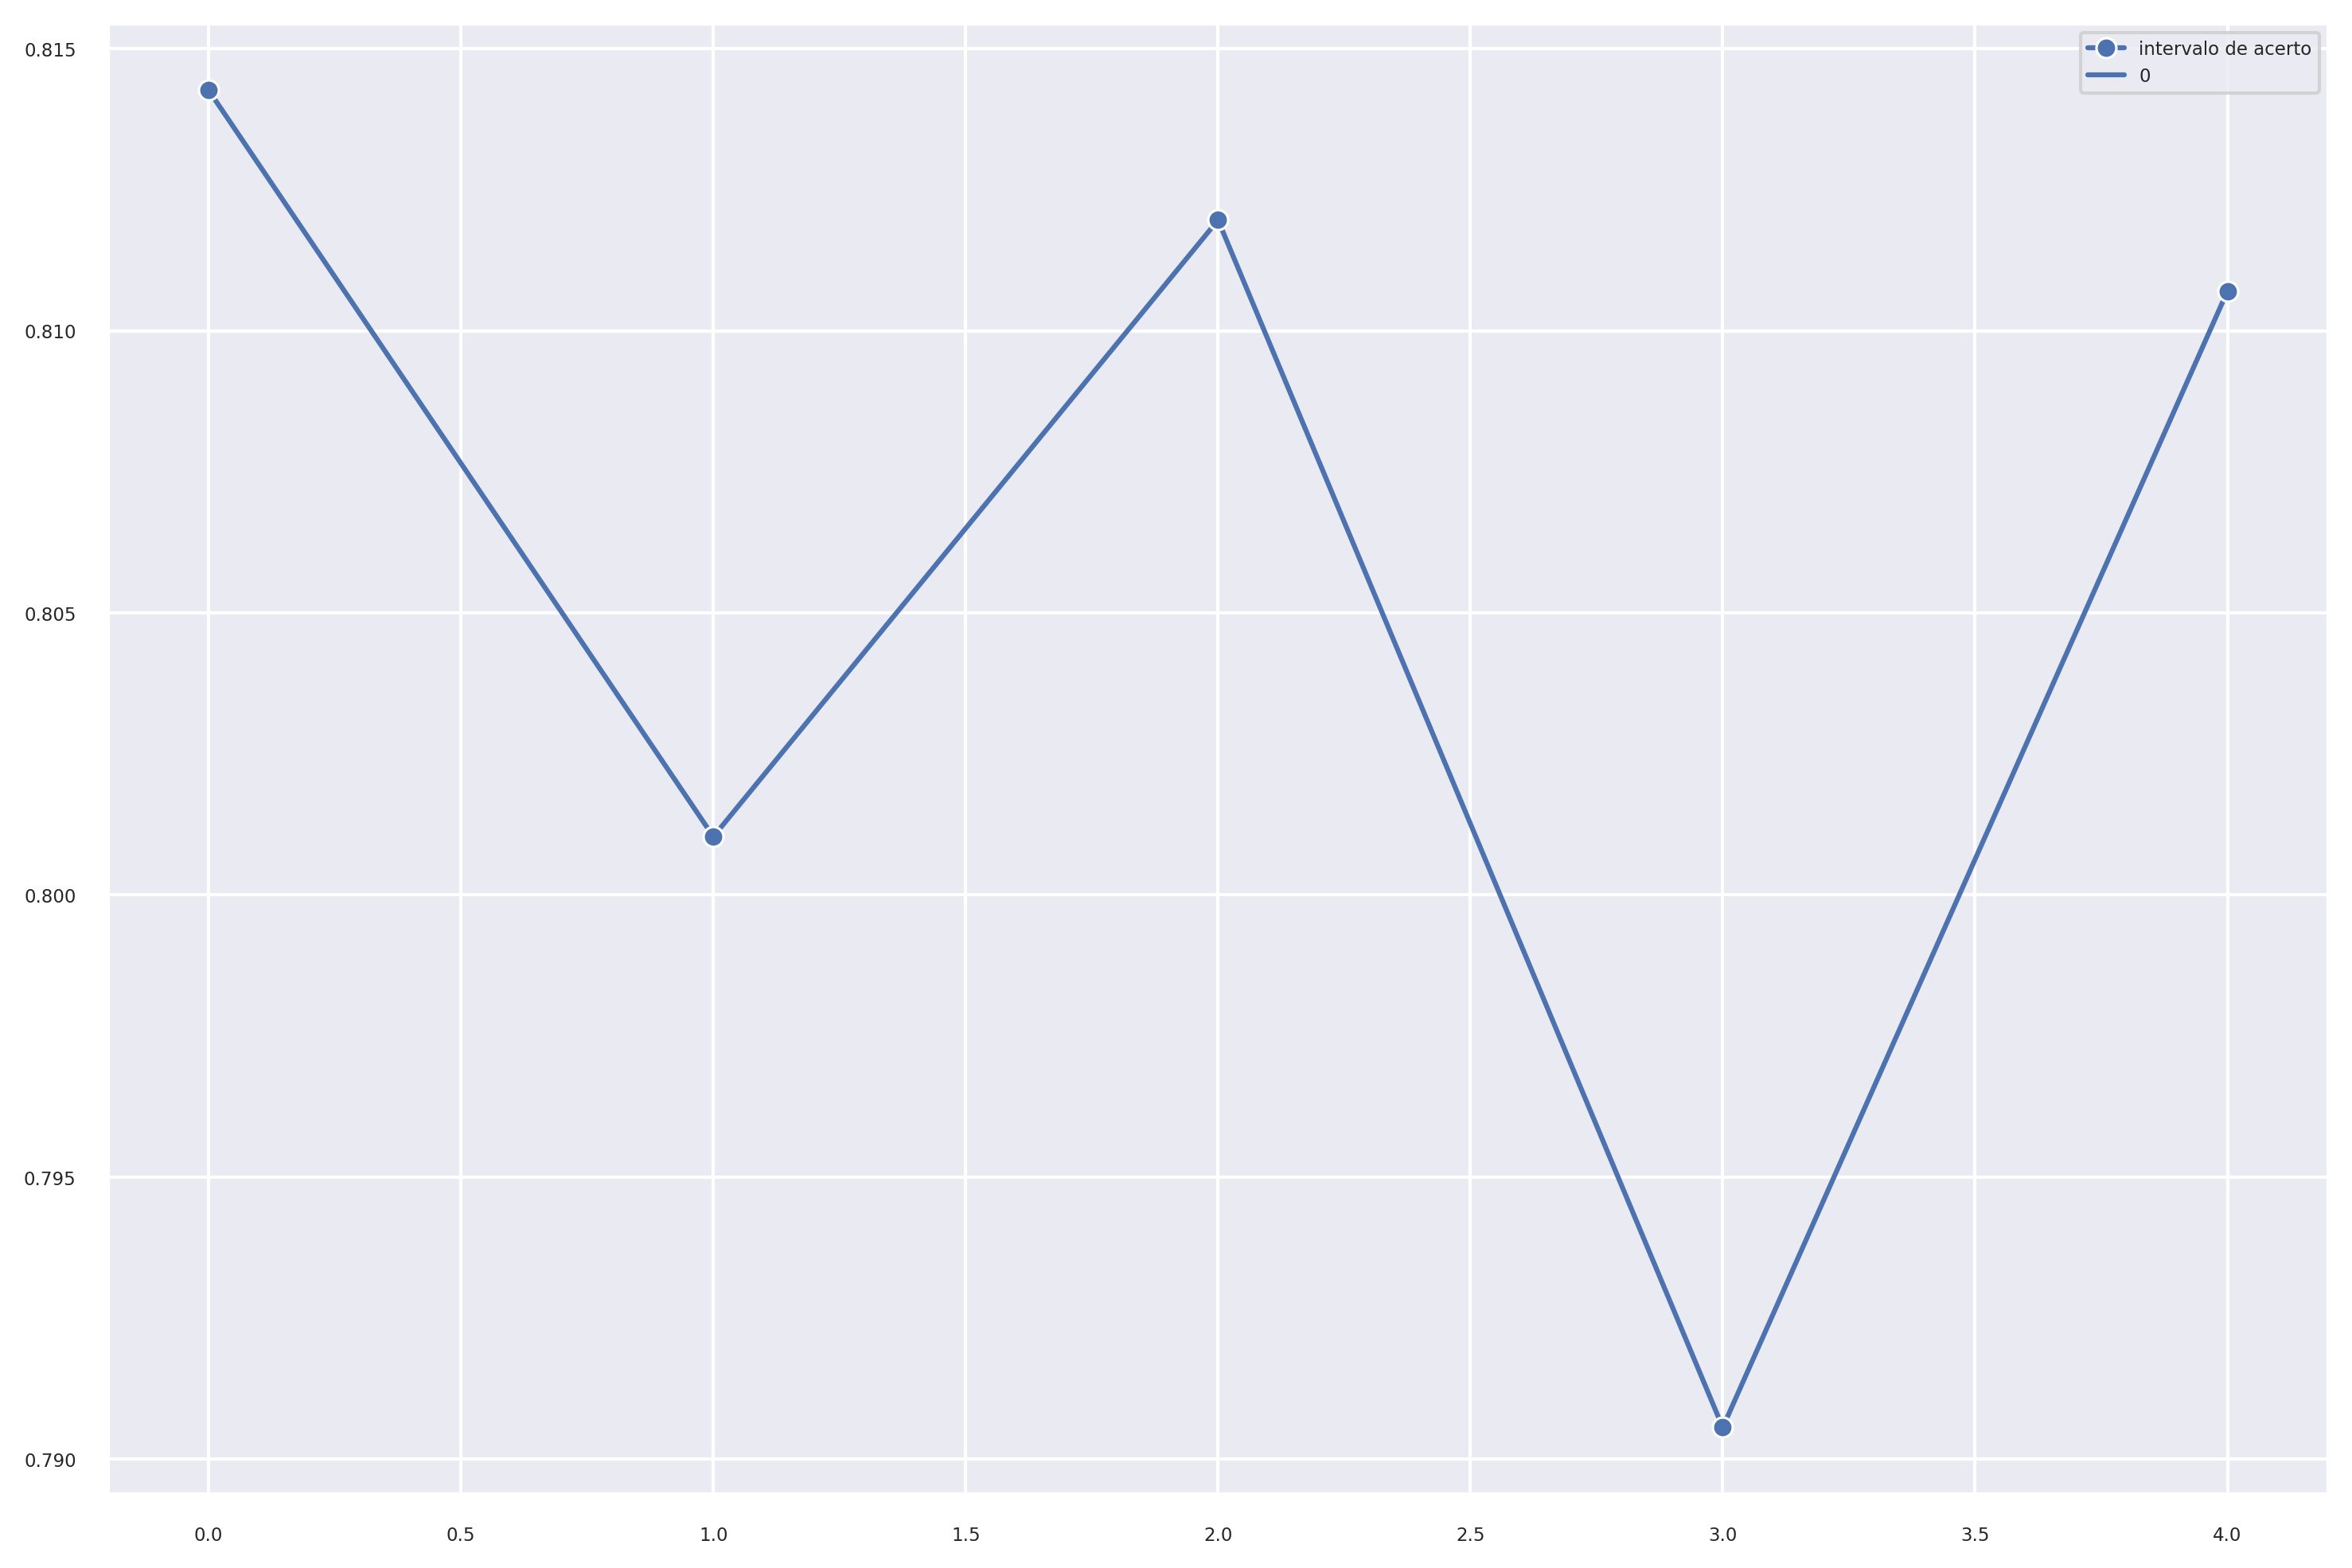

In [ ]:
model_gbc = GradientBoostingClassifier(random_state=0)
model_gbc.fit(x_train_v6,y_train_v2)
performance = cross_val_score(model_v4,x_train_v6,y_train_v2,cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=0))
fig,ax = plt.subplots(figsize=(12,8),dpi=300)
sns.lineplot(data=pd.DataFrame(performance),color="blue",marker="o",label="intervalo de acerto")
plt.show()

Tratando dados de teste e salvando as previsões do modelo

In [ ]:
x_test_final_v2.drop(["deck_nan","Destination_nan","HomePlanet_nan","side_P","deck_T","side_nan","VIP"],axis=1,inplace=True)
x_test_final_v2["Grupo"] = x_test_final_v2["Grupo"].apply(int)
x_test_final_v2["num"] = x_test_final_v2["num"].apply(int)

In [ ]:
model_v4.fit(x_train_v6,y_train_v2)
y_predict = model_v4.predict(x_test_final_v2)
y_predict_df = pd.DataFrame(y_predict,columns=y_train.columns)
submission_df = pd.concat([x_test["PassengerId"],y_predict_df],axis=1)
submission_df["Transported"] = submission_df["Transported"].map({0:False,1:True})
submission_df.to_csv("/content/submission_1.csv",index=False)

Visualizando a importância de cada feature para a performance do modelo

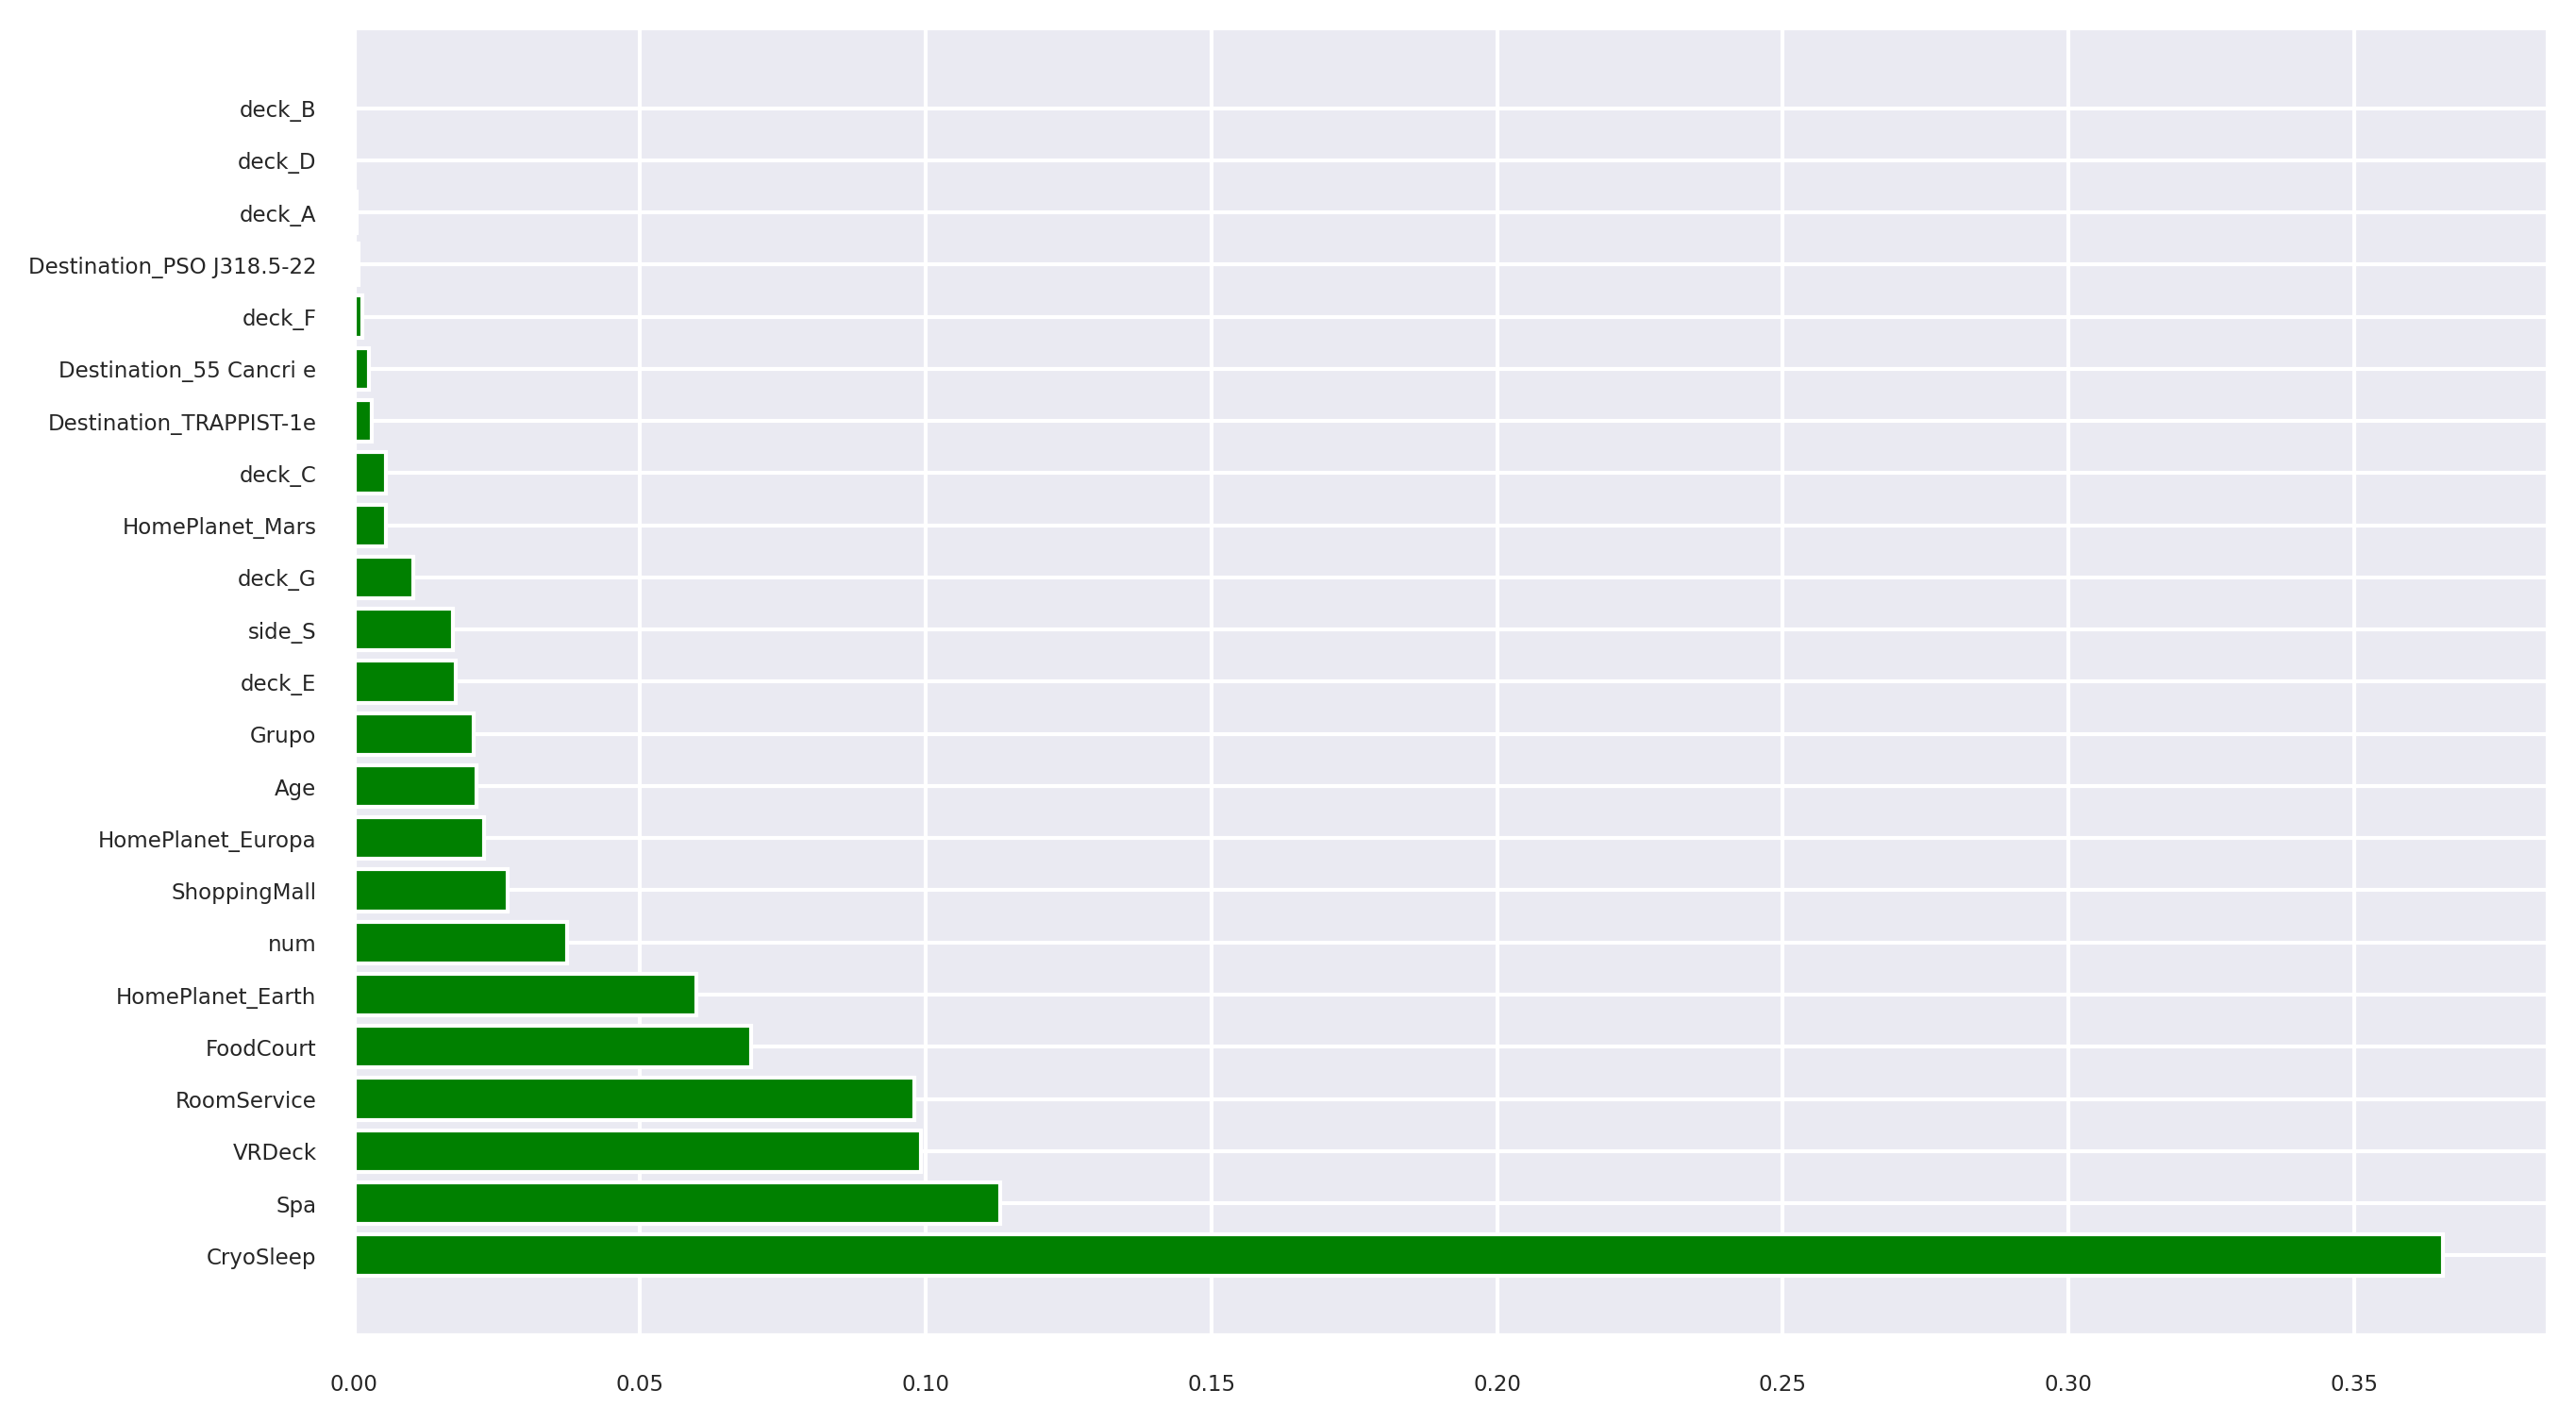

In [ ]:
model_gbc.fit(x_train_v6,y_train_v2)
feature_importance = pd.DataFrame(model_gbc.feature_importances_,columns=["Valores"])
columns = pd.DataFrame(x_train_v6.columns,columns=["Labels"])
temp = pd.concat([columns,feature_importance],axis=1)
temp = temp.sort_values(by="Valores",ascending=False)
fig,ax = plt.subplots(figsize=(10,6),dpi=300)
plt.barh(range(x_train_v6.shape[1]),temp.Valores,tick_label=temp.Labels,color="green")
plt.show()

Visualizando a distribuiçao das idades e seus outliers

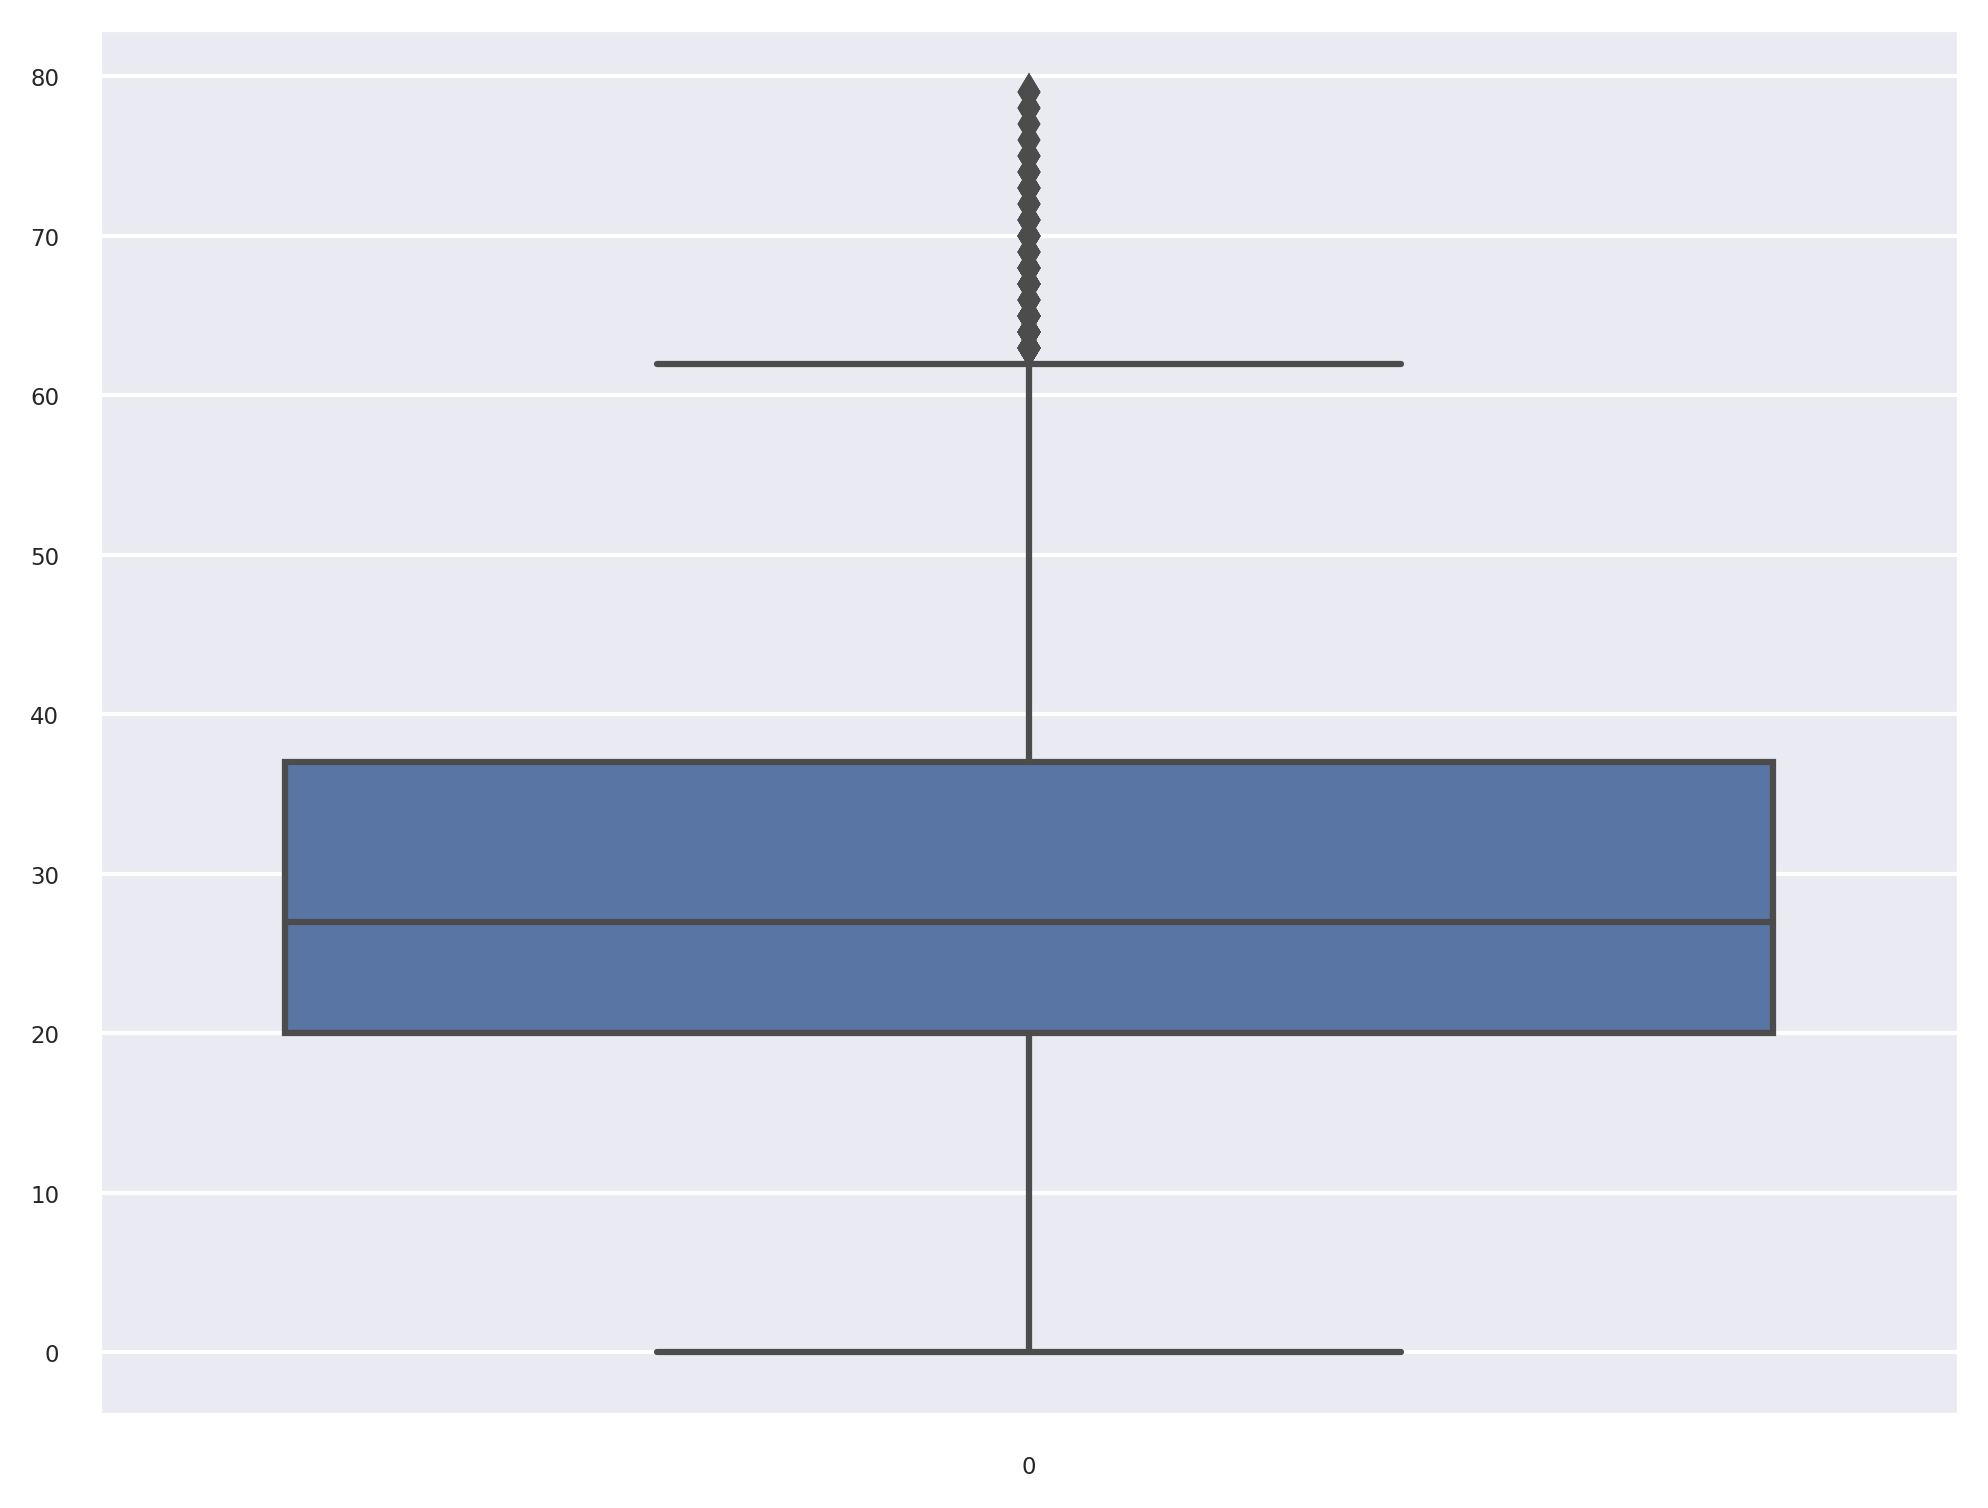

In [ ]:
#Verifica-se outliers nas idades +60
fig,ax = plt.subplots(figsize=(8,6),dpi=300)
sns.boxplot(x_train_v6.Age)
plt.show()

Padronizando e visualizando a distribuição dos gastos em Spa

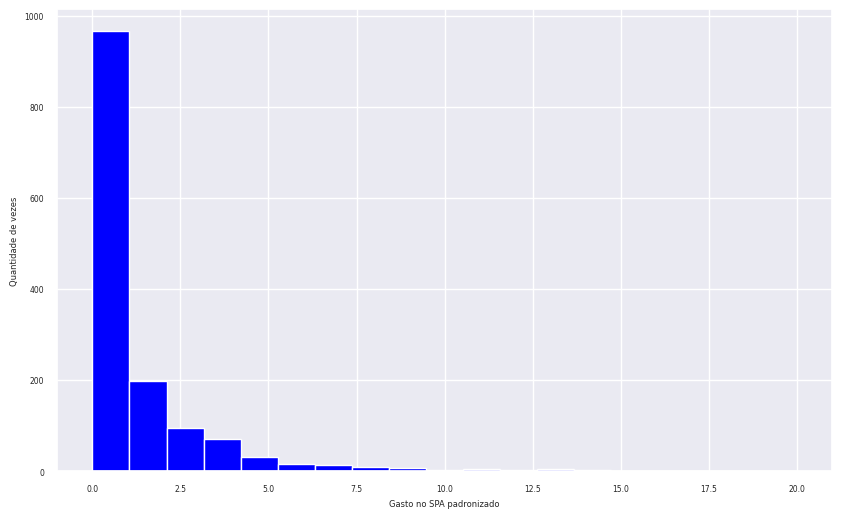

In [ ]:
scaler = StandardScaler()
temp_1 = scaler.fit_transform(x_train_v6)
x_train_v7 = pd.DataFrame(temp_1,columns=x_train_v6.columns)
fig,ax = plt.subplots(figsize=(10,6))
plt.ylabel("Quantidade de vezes")
plt.xlabel("Gasto no SPA padronizado")
bins = (x_train_v7.Spa.max())
plt.hist(x_train_v7.Spa,color="blue",bins=int(bins),range=[0,20])
plt.show()

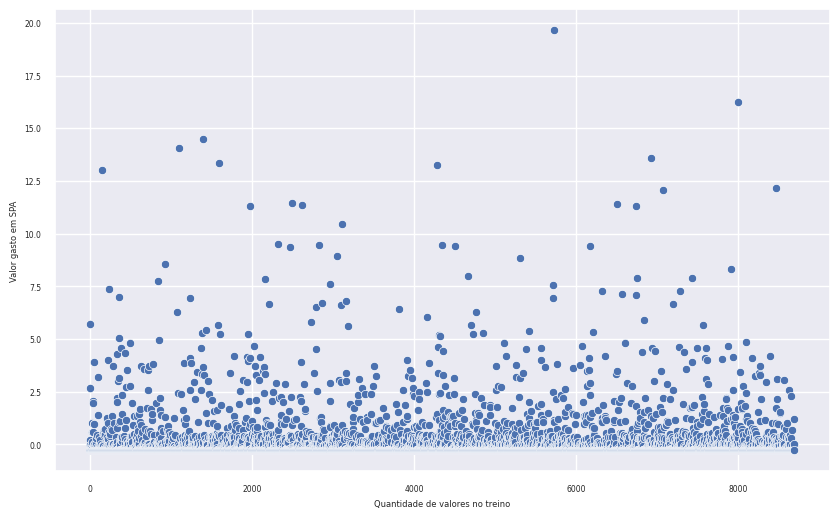

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x_train_v7.Spa)
plt.ylabel("Valor gasto em SPA")
plt.xlabel("Quantidade de valores no treino")
plt.show()

Checando o número de outliers e fazendo a transformação logaritmica neles para reduzir a infuência deles na performance

In [ ]:
def verifica_outlier(n):
  limite_superior = n.mean() + 3*n.std()
  print(f"Existem {n[n >= limite_superior].count()} outliers e seu valor limite é {limite_superior}")

Existem 175 outliers e seu valor limite é 3.0001725675171835


<Axes: ylabel='Spa'>

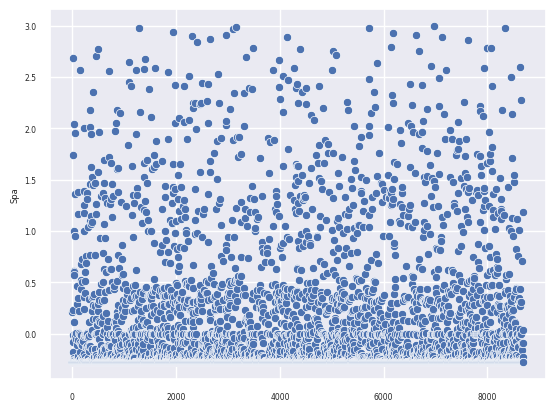

In [ ]:
verifica_outlier(x_train_v7.Spa)
def transformacao_log(n):
  if n <= 3:
    return n
  else:
    n_1 = np.log(n)
    return n_1
x_train_v8 = pd.DataFrame(x_train_v7)
x_train_v8.Spa = x_train_v8.Spa.apply(transformacao_log)
sns.scatterplot(x_train_v8.Spa)

In [ ]:
def testando_modelo_v5(n):
  cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
  intervalo = cross_val_score(n,x_train_v8,y_train_v2,cv=cv)
  print(f"O intervalo de precisão de {n} é entre {(intervalo.mean() - 2*intervalo.std()):.3f} e {(intervalo.mean() + 2*intervalo.std()):.3f}")

Com isso concluimos que o tratamento de outliers não afetou a performance do modelo de maneira relevante, mesmo sendo a segunda feature mais importante para o modelo

In [ ]:
model_gbc = GradientBoostingClassifier(random_state=0)
model_gbc.fit(x_train_v8,y_train_v2)
print("Modelo normalizado e com correção de outliers em SPA:")
testando_modelo_v5(model_gbc)
model_gbc.fit(x_train_v6,y_train_v2)
print("Modelo não normalizado e sem correção de outliers em SPA:")
testando_modelo_v4(model_gbc)

Modelo normalizado e com correção de outliers em SPA
O intervalo de precisão de GradientBoostingClassifier(random_state=0) é entre 0.791 e 0.819
Modelo não normalizado e sem correção de outliers em SPA
O intervalo de precisão de GradientBoostingClassifier(random_state=0) é entre 0.793 e 0.815


Criando uma nova feature com base no total gasto por cada passageiro

In [ ]:
total_spent = pd.DataFrame([x_train_v7.FoodCourt + x_train_v7.Spa + x_train_v3.ShoppingMall + x_train_v7.VRDeck])
total_spent_transformed = total_spent.melt()
total_spent_v2 = total_spent_transformed["value"]
x_train_v9 = pd.concat([x_train_v8,total_spent_v2],axis=1)
x_train_v9.rename(columns={"value":"TotalSpent"},inplace=True)

Testando a performance do modelo após a adição da nova feature, porém foi concluído que a nova feature não melhorou o modelo de maneira significativa

In [ ]:
model_gbc.fit(x_train_v9,y_train_v2)
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
intervalo = cross_val_score(model_gbc,x_train_v9,y_train_v2,cv=cv)
print(f"O intervalo de precisão de {model_gbc} é entre {(intervalo.mean() - 2*intervalo.std()):.3f} e {(intervalo.mean() + 2*intervalo.std()):.3f}")

O intervalo de precisão de LGBMClassifier(random_state=0) é entre 0.799 e 0.820
O intervalo de precisão de <catboost.core.CatBoostClassifier object at 0x79f950106ec0> é entre 0.811 e 0.821
O intervalo de precisão de GradientBoostingClassifier() é entre 0.793 e 0.817
O intervalo de precisão de RandomForestClassifier(random_state=0) é entre 0.789 e 0.808


Analisando a importância de cada feature para o modelo pós adição da nova feature

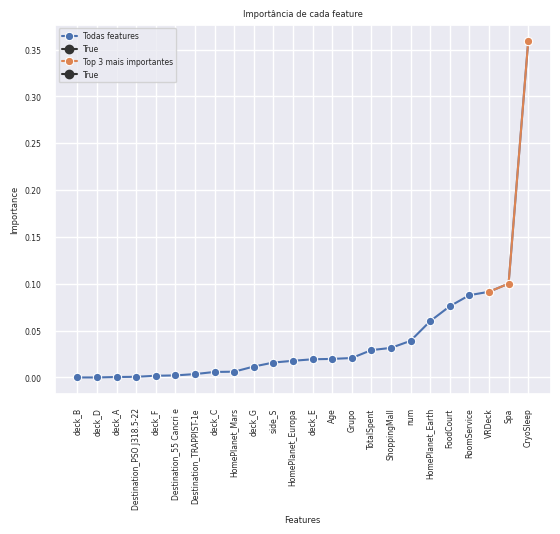

In [ ]:
feature_importance_v2 = pd.concat([pd.DataFrame(model_gbc.feature_importances_,columns=["Importance"]),pd.DataFrame(x_train_v9.columns,columns=["Features"])],axis=1)
feature_importance_v2.sort_values(by="Importance",inplace=True)
sns.lineplot(data=feature_importance_v2,x="Features",y="Importance",markers="o",style=True,label="Todas features")
sns.lineplot(data=feature_importance_v2.tail(3),x="Features",y="Importance",markers="o",style=True,label="Top 3 mais importantes")
plt.title("Importância de cada feature")
plt.xticks(rotation=90)
plt.show()

Apesar dos diferentes tratamentos de dados foi possível concluir que eles não geraram melhora na performance do modelo, portanto será feita a otimização dos hiperparâmetros

**OBS: Grande tempo de demora para realizar a busca, não rode sem ter noção disso!**

In [157]:
parametros = {
    "n_estimators": [80, 100, 300, 500],
    "max_leaf_nodes": [None,2, 5, 10, 20, 50],
    "learning_rate": [0.7,0.8,1.0,1.2,1.4]
}
cv=StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(model_gbc,parametros,n_jobs=-1,verbose=2)
grid_search.fit(x_train_v9,y_train_v2)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'learning_rate': 0.7, 'max_leaf_nodes': 2, 'n_estimators': 80}
0.6934341191814933


Modelo StackingClassifier para reunir os diversos modelos e dessa forma tentar produzir um resultado melhor

In [ ]:
estimadores_base = [("ctb",ctb.CatBoostClassifier(verbose=0,random_state=0)),("lgbm",LGBMClassifier(random_state=0),("xgbc",XGBClassifier(random_state=0)),("gbc",GradientBoostingClassifier(random_state=0)))]
estimador_final = LogisticRegression(random_state=0)
stacking_model = StackingClassifier(estimators=estimadores_base,final_estimator=estimador_final)
stacking_model.fit(x_train_v6,y_train_v2)
cv=StratifiedKFold(shuffle=True,n_splits=5,random_state=0)
intervalo = cross_val_score(stacking_model,x_train_v9,y_train_v2,cv=cv)
intervalo

array([0.80276021, 0.80448534, 0.8200115 , 0.80897583, 0.81588032])